In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from scikeras.wrappers import KerasRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
def preprocess_data(df, product_name):
    """
    Preprocess data for a single product:
    - Filters product-specific data
    - Sorts by year and week number
    - Normalizes TotalQuantity
    """
    # Filter data for selected product
    product_df = df[df['Product_Name'] == product_name].copy()

    # Sort by Year THEN WeekNumber
    product_df = product_df.sort_values(['Year', 'Week_Number']).reset_index(drop=True)

    # Extract TotalQuantity as numpy array
    data = product_df['Total_Quantity'].values.reshape(-1, 1)

    # Handle missing values
    data = np.nan_to_num(data)

    # Normalize between 0 and 1
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(data)

    return scaled_data, scaler, product_df, data


def create_dataset(scaled_data, time_steps=12):
    """
    Creates sequences of data for LSTM input:
    - X: past time steps
    - y: next step prediction target
    """

    X, y = [], []
    for i in range(len(scaled_data) - time_steps):
        X.append(scaled_data[i:(i + time_steps), 0])  # take past demand
        y.append(scaled_data[i + time_steps, 0])      # predict next demand
    X = np.array(X)
    y = np.array(y)
    return X, y





In [3]:
file_path = "../data/demand_prediction_weekly_2015_2025.xlsx"
df = pd.read_excel(file_path)

In [20]:
scaled_data, scaler, product_df, data = preprocess_data(df, "TIBRIO")
X, y = create_dataset(scaled_data,time_steps=2)
X = X.reshape((X.shape[0], X.shape[1], 1))

In [21]:
train_size = int(0.7 * len(X))
test_size = int(0.85 * len(X))
    
X_train, y_train = X[:train_size], y[:train_size]
X_test, y_test = X[train_size:test_size], y[train_size:test_size]
X_val, y_val = X[test_size:], y[test_size:]
    
# Reshape for LSTM input
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))

In [22]:
from tensorflow.keras.models import load_model

model = load_model("../saved models/good.keras")

In [28]:
from tensorflow.keras.optimizers import Adam

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss="mse",  # adjust if using something else
    metrics=["accuracy"]
)

In [29]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [31]:
model.fit(
    X_train, y_train,
    epochs=1000,
    batch_size=2,
    validation_data=(X_val, y_val),
    verbose=2,
    shuffle=False,
    #callbacks=[early_stop]
)

Epoch 1/1000
165/165 - 0s - 3ms/step - accuracy: 0.0669 - loss: 0.0325 - val_accuracy: 0.0000e+00 - val_loss: 0.0458
Epoch 2/1000
165/165 - 0s - 2ms/step - accuracy: 0.0669 - loss: 0.0325 - val_accuracy: 0.0000e+00 - val_loss: 0.0451
Epoch 3/1000
165/165 - 0s - 2ms/step - accuracy: 0.0669 - loss: 0.0325 - val_accuracy: 0.0000e+00 - val_loss: 0.0456
Epoch 4/1000
165/165 - 0s - 2ms/step - accuracy: 0.0669 - loss: 0.0325 - val_accuracy: 0.0000e+00 - val_loss: 0.0456
Epoch 5/1000
165/165 - 0s - 2ms/step - accuracy: 0.0669 - loss: 0.0325 - val_accuracy: 0.0000e+00 - val_loss: 0.0450
Epoch 6/1000
165/165 - 0s - 2ms/step - accuracy: 0.0669 - loss: 0.0325 - val_accuracy: 0.0000e+00 - val_loss: 0.0456
Epoch 7/1000
165/165 - 0s - 2ms/step - accuracy: 0.0669 - loss: 0.0324 - val_accuracy: 0.0000e+00 - val_loss: 0.0449
Epoch 8/1000
165/165 - 0s - 2ms/step - accuracy: 0.0669 - loss: 0.0325 - val_accuracy: 0.0000e+00 - val_loss: 0.0454
Epoch 9/1000
165/165 - 0s - 2ms/step - accuracy: 0.0669 - loss: 

In [32]:
predictions = model.predict(X_test)
    
# Inverse transform to original scale
predictions = scaler.inverse_transform(predictions)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

predictions1 = scaler.inverse_transform(model.predict(X))
y1 = scaler.inverse_transform(y.reshape(-1, 1))

rmse = np.sqrt(np.mean((y_test_actual - predictions) ** 2))
    
# Calculate SMAPE (equation 12)
smape = np.mean(2 * np.abs(y_test_actual - predictions) / 
                (np.abs(y_test_actual) + np.abs(predictions)))
    
mae = mean_absolute_error(y_test_actual, predictions)
accuracy = max(0, (1 - (mae / np.mean(y_test_actual))) * 100)


print("RMSE",rmse)
print("SMAPE:" ,smape)
print(f"✅ Accuracy (approx): {accuracy:.2f}%")
print(" Mean Absolute Error (MAE):",mae)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
RMSE 10.147131293888549
SMAPE: 0.6569376628800112
✅ Accuracy (approx): 35.37%
 Mean Absolute Error (MAE): 9.001537990570068


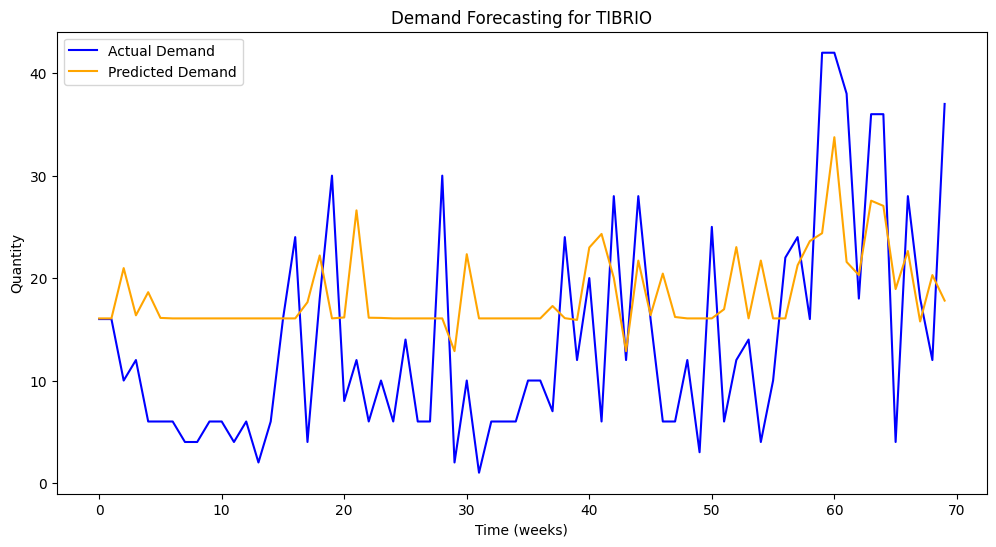

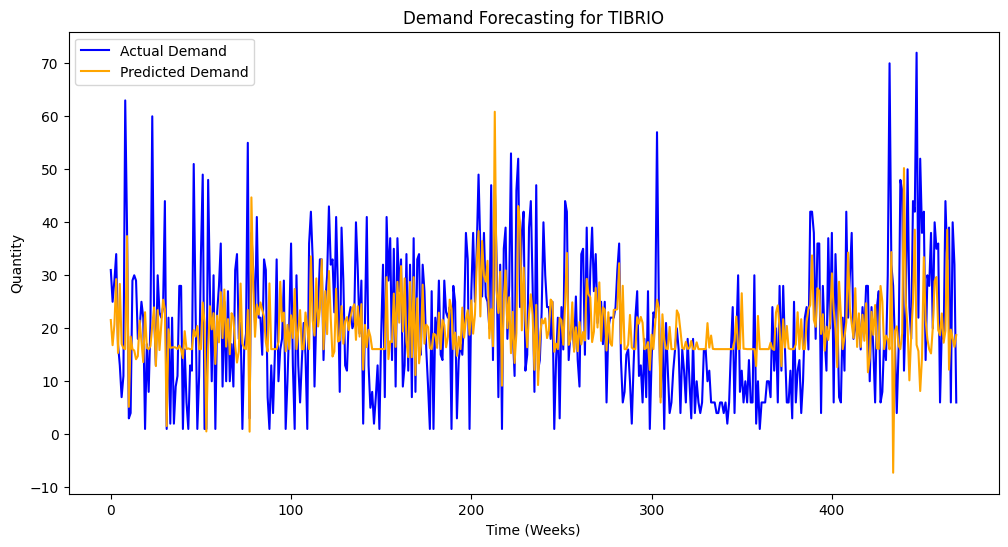

In [33]:
plt.figure(figsize=(12,6))
plt.plot(y_test_actual, label='Actual Demand', color='blue')
plt.plot(predictions, label='Predicted Demand', color='orange')
plt.title(f"Demand Forecasting for TIBRIO")
plt.xlabel("Time (weeks)")
plt.ylabel("Quantity")
plt.legend()
plt.show()


plt.figure(figsize=(12,6))
plt.plot(y1, label='Actual Demand', color='blue')
plt.plot(predictions1, label='Predicted Demand', color='orange')
plt.title(f"Demand Forecasting for TIBRIO")
plt.xlabel("Time (Weeks)")
plt.ylabel("Quantity")
plt.legend()
plt.show()